In [1]:
import yfinance as yf
import pandas as pd

# Define the list of tickers and the data period
tickers = ['NVDA', 'META', 'KO', 'AAPL', 'GOOG']
data = yf.download(tickers, start='2015-01-01', end='2024-10-29')['Adj Close']

# Select the last available date's prices for calculation
last_prices = data.iloc[-1]

# Set the number of stocks in the index and the initial divisor (consider it equal to N initially)
N = len(tickers)
D_t = N  # Initial divisor

# Calculate the initial PWI value
price_sum = last_prices.sum()
PWI_initial = price_sum / D_t
print("Initial price-weighted index (PWI) value:", PWI_initial)

# Simulate a stock split (e.g., a 2-for-1 split for AAPL)
split_ticker = 'AAPL'
split_factor = 2
last_prices[split_ticker] /= split_factor  # Adjust the price for the split

# Recalculate the sum of prices and adjust the divisor to maintain consistency
new_price_sum = last_prices.sum()
D_t_new = new_price_sum / PWI_initial  # New adjusted divisor
print("Adjusted divisor after split:", D_t_new)

# Calculate the new PWI after adjustment
PWI_adjusted = new_price_sum / D_t_new
print("New price-weighted index (PWI) value after adjustment:", PWI_adjusted)


[*********************100%***********************]  5 of 5 completed

Initial price-weighted index (PWI) value: 237.4179931640625
Adjusted divisor after split: 4.508461867641181
New price-weighted index (PWI) value after adjustment: 237.4179931640625



<ipython-input-1-965fbd3f2aa5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_prices[split_ticker] /= split_factor  # Adjust the price for the split


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define an expanded list of asset tickers (e.g., stocks, ETFs, bonds, commodities)
tickers = ['NVDA', 'META', 'KO', 'AAPL', 'GOOG', 'SPY', 'NQ=F']

# Download historical data for all assets
data = yf.download(tickers, start='2015-01-01', end='2024-10-29')['Adj Close']

# Calculate daily returns for each asset
returns = data.pct_change().dropna()

# Define the performance metrics function (Sharpe Ratio, Max Drawdown)
def calculate_metrics(returns, risk_free_rate=0.015):
    metrics = pd.DataFrame(index=returns.columns, columns=['Annualized Return', 'Volatility', 'Sharpe Ratio', 'Max Drawdown'])

    for ticker in returns.columns:
        # Calculate annualized return
        annual_return = returns[ticker].mean() * 252

        # Calculate annualized volatility
        annual_volatility = returns[ticker].std() * np.sqrt(252)

        # Calculate Sharpe Ratio
        sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

        # Calculate cumulative returns
        cumulative_returns = (1 + returns[ticker]).cumprod()

        # Calculate Maximum Drawdown
        running_max = cumulative_returns.cummax()
        drawdown = cumulative_returns / running_max - 1
        max_drawdown = drawdown.min()

        # Store the metrics in the dataframe
        metrics.loc[ticker] = [annual_return, annual_volatility, sharpe_ratio, max_drawdown]

    return metrics

# Calculate metrics for each asset
metrics = calculate_metrics(returns)
print("Performance Metrics for the Expanded Asset Universe:\n", metrics)

# Relaxed filter conditions: Sharpe Ratio > 0.3 and Max Drawdown > -40%
selected_portfolio = metrics[(metrics['Sharpe Ratio'] > 0.3) & (metrics['Max Drawdown'] > -0.4)]

# If no assets meet the criteria, select the top 3 based on Sharpe Ratio
if selected_portfolio.empty:
    print("\nNo assets meet the Sharpe Ratio > 0.3 and Max Drawdown > -40% criteria.")
    selected_portfolio = metrics.sort_values(by='Sharpe Ratio', ascending=False).head(3)

print("\nSelected Portfolio Based on Relaxed Criteria or Top 3 by Sharpe Ratio:\n", selected_portfolio)

# 1. Normalize Sharpe Ratios to use as weights
sharpe_ratios = selected_portfolio['Sharpe Ratio'].astype(float)
weights = sharpe_ratios / sharpe_ratios.sum()  # Sharpe Ratio-weighted portfolio

print("\nSharpe Ratio-based Weights:\n", weights)

# Backtesting the Portfolio Strategy
# Rebalance portfolio at the start of each year
start_date = '2015-01-01'
end_date = '2024-10-29'
data_selected = data[selected_portfolio.index]

# Normalize prices
normalized_data = data_selected / data_selected.iloc[0]

# Calculate portfolio returns: Sharpe Ratio-weighted strategy
portfolio_returns = (returns[selected_portfolio.index] @ weights).dropna()

# Cumulative return of the portfolio
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

# Cumulative return of the S&P 500 (benchmark)
cumulative_benchmark_SPY = (1 + returns['SPY']).cumprod()
cumulative_benchmark_NQF = (1 + returns['NQ=F']).cumprod()



# Evaluate performance against the benchmark
def performance_summary(returns, risk_free_rate=0.015):
    ann_return = returns.mean() * 252
    ann_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility
    return ann_return, ann_volatility, sharpe_ratio

portfolio_ann_return, portfolio_ann_volatility, portfolio_sharpe_ratio = performance_summary(portfolio_returns)
benchmark_ann_return, benchmark_ann_volatility, benchmark_sharpe_ratio = performance_summary(returns['SPY'])

print("\nPerformance Summary:\n")
print(f"Portfolio - Annualized Return: {portfolio_ann_return:.2%}, Volatility: {portfolio_ann_volatility:.2%}, Sharpe Ratio: {portfolio_sharpe_ratio:.2f}")
print(f"S&P 500 - Annualized Return: {benchmark_ann_return:.2%}, Volatility: {benchmark_ann_volatility:.2%}, Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")


[*********************100%***********************]  7 of 7 completed
<ipython-input-2-5b263346c4e4>:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


Performance Metrics for the Expanded Asset Universe:
        Annualized Return Volatility Sharpe Ratio Max Drawdown
Ticker                                                       
AAPL            0.271384   0.286275     0.895587    -0.385159
GOOG            0.230324   0.284133      0.75783    -0.446018
KO               0.09442    0.17838     0.445231    -0.369875
META             0.27561   0.376312     0.692537    -0.767361
NQ=F            0.185314   0.218804     0.778388     -0.35276
NVDA            0.696616   0.487859     1.397158    -0.663351
SPY             0.139085   0.176774     0.701942    -0.337173

Selected Portfolio Based on Relaxed Criteria or Top 3 by Sharpe Ratio:
        Annualized Return Volatility Sharpe Ratio Max Drawdown
Ticker                                                       
AAPL            0.271384   0.286275     0.895587    -0.385159
KO               0.09442    0.17838     0.445231    -0.369875
NQ=F            0.185314   0.218804     0.778388     -0.35276
SPY  

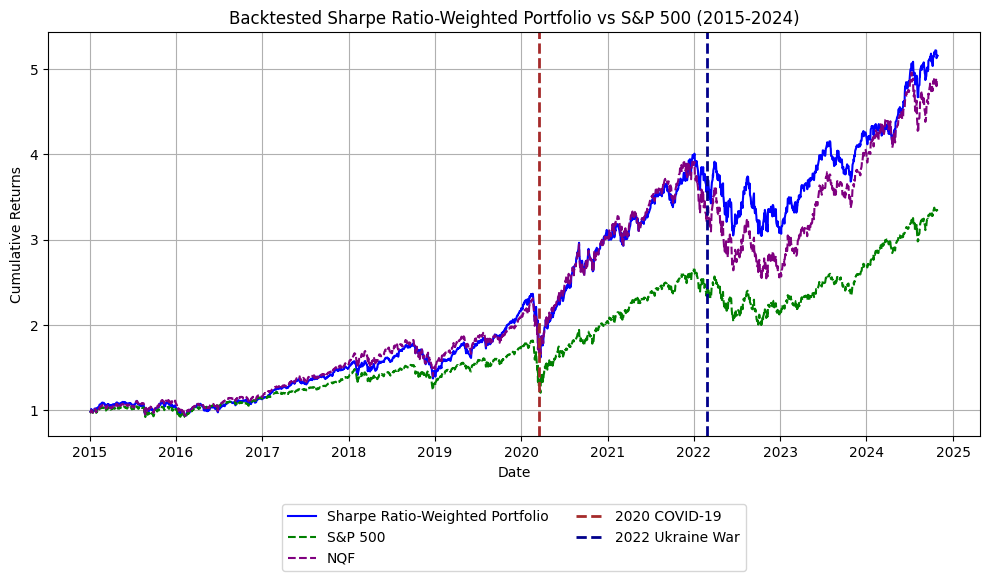

In [3]:
# Define crash dates and labels
crash_dates = pd.to_datetime(['2020-03-16', '2022-02-24']).tz_localize('UTC')
crash_labels = ['2020 COVID-19', '2022 Ukraine War']
line_colors = ['brown', 'darkblue']  # Different colors for vertical bars


plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns, label="Sharpe Ratio-Weighted Portfolio", color='blue')
plt.plot(cumulative_benchmark_SPY, label="S&P 500", color='green', linestyle='--')
plt.plot(cumulative_benchmark_NQF, label="NQF", color='purple', linestyle='--')

# Add vertical lines for crash events
for i, crash_date in enumerate(crash_dates):
    plt.axvline(x=crash_date, color=line_colors[i], linestyle='--', linewidth=2, label=crash_labels[i])

# Set titles and labels
plt.title("Backtested Sharpe Ratio-Weighted Portfolio vs S&P 500 (2015-2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")

# Move legend outside and set transparent background
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.grid(True)

# Save the plot with a transparent background
plt.tight_layout()
plt.savefig("sharpe_ratio_portfolio_vs_sp500.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()



In [4]:
# Evaluate performance against the benchmark
def performance_summary(returns, risk_free_rate=0.015):
    ann_return = returns.mean() * 252
    ann_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility
    return ann_return, ann_volatility, sharpe_ratio

portfolio_ann_return, portfolio_ann_volatility, portfolio_sharpe_ratio = performance_summary(portfolio_returns)
benchmark_ann_return, benchmark_ann_volatility, benchmark_sharpe_ratio = performance_summary(returns['SPY'])
nasdaq_ann_return, nasdaq_ann_volatility, nasdaq_sharpe_ratio = performance_summary(returns['NQ=F'])


print("\nPerformance Summary:\n")
print(f"Portfolio - Annualized Return: {portfolio_ann_return:.2%}, Volatility: {portfolio_ann_volatility:.2%}, Sharpe Ratio: {portfolio_sharpe_ratio:.2f}")
print(f"S&P 500 - Annualized Return: {benchmark_ann_return:.2%}, Volatility: {benchmark_ann_volatility:.2%}, Sharpe Ratio: {benchmark_sharpe_ratio:.2f}")
print(f"NASDAQ-100 - Annualized Return: {nasdaq_ann_return:.2%}, Volatility: {nasdaq_ann_volatility:.2%}, Sharpe Ratio: {nasdaq_sharpe_ratio:.2f}")


Performance Summary:

Portfolio - Annualized Return: 18.68%, Volatility: 19.75%, Sharpe Ratio: 0.87
S&P 500 - Annualized Return: 13.91%, Volatility: 17.68%, Sharpe Ratio: 0.70
NASDAQ-100 - Annualized Return: 18.53%, Volatility: 21.88%, Sharpe Ratio: 0.78


[*********************100%***********************]  4 of 4 completed
<ipython-input-40-b6fd0e5f166a>:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


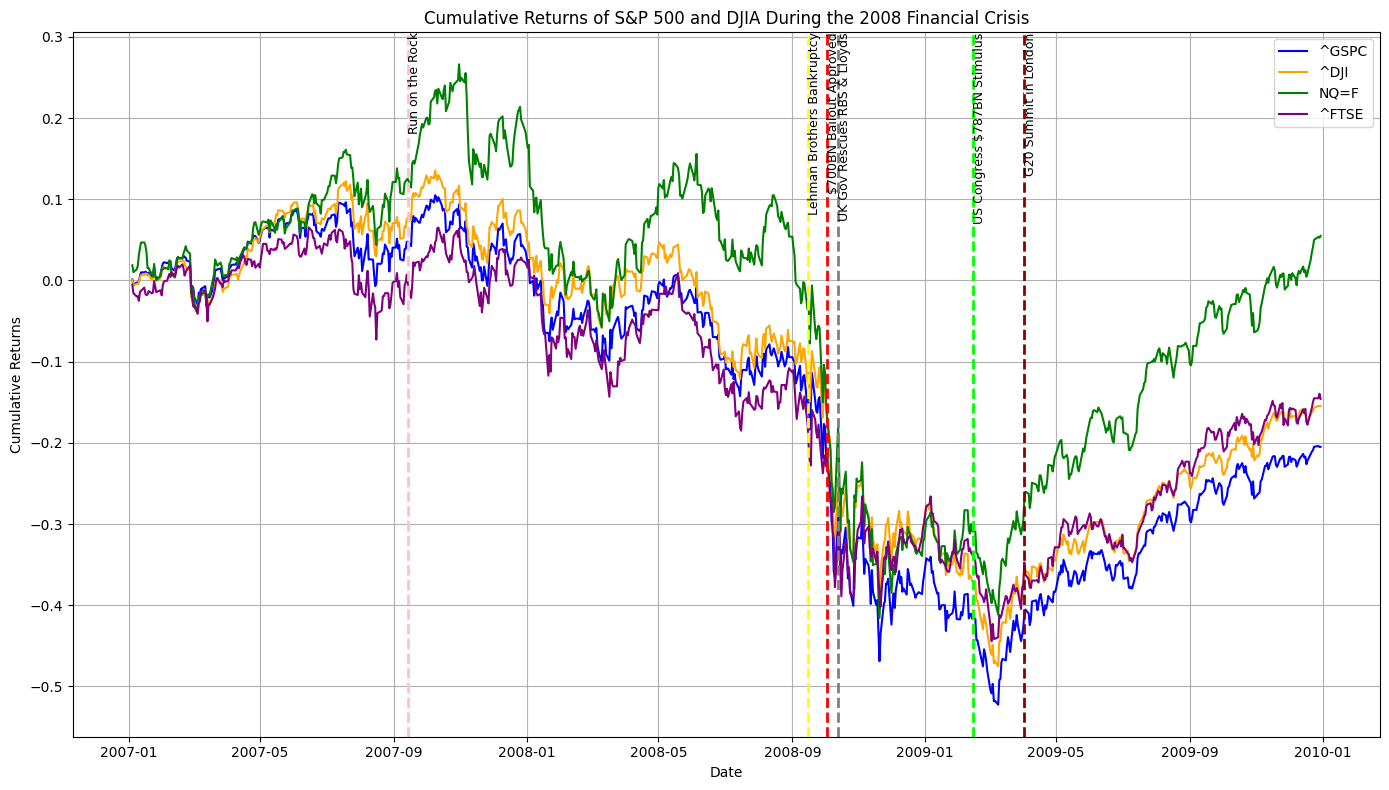

Cumulative Returns Data:
 Ticker                         NQ=F      ^DJI     ^FTSE     ^GSPC
Date                                                             
2007-01-04 00:00:00+00:00  0.018690  0.000495 -0.005064  0.001228
2007-01-05 00:00:00+00:00  0.010259 -0.006133 -0.015651 -0.004864
2007-01-08 00:00:00+00:00  0.013772 -0.004091 -0.019750 -0.002654
2007-01-09 00:00:00+00:00  0.017707 -0.004643 -0.019449 -0.003170
2007-01-10 00:00:00+00:00  0.031197 -0.002594 -0.025051 -0.001235
...                             ...       ...       ...       ...
2009-12-23 00:00:00+00:00  0.041175 -0.160974 -0.149802 -0.208958
2009-12-24 00:00:00+00:00  0.050028 -0.156674 -0.145055 -0.204800
2009-12-28 00:00:00+00:00  0.053682 -0.154510 -0.145055 -0.203883
2009-12-29 00:00:00+00:00  0.052558 -0.154644 -0.139484 -0.204998
2009-12-30 00:00:00+00:00  0.054947 -0.154396 -0.145767 -0.204843

[769 rows x 4 columns]


In [40]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Define the tickers for S&P 500 and DJIA
tickers = ['^GSPC', '^DJI', 'NQ=F', '^FTSE']

# Download historical data for S&P 500 and DJIA from Yahoo Finance
data = yf.download(tickers, start='2007-01-01', end='2009-12-31')['Adj Close']

# Calculate daily percentage change and cumulative returns
returns = data.pct_change().dropna()
cumulative_returns = (1 + returns).cumprod() - 1

# Key events during the 2008 financial crisis
events = {
    'Run on the Rock': ('2007-09-14', 'pink'),
    'Lehman Brothers Bankruptcy': ('2008-09-15', 'yellow'),
    '$700BN Bailout Approved': ('2008-10-03', 'red'),
    'UK Gov Rescues RBS & Lloyds': ('2008-10-13', 'grey'),
    'US Congress $787BN Stimulus': ('2009-02-14', 'lime'),
    'G20 Summit in London': ('2009-04-02', 'darkred')
}


# Plotting the cumulative returns
plt.figure(figsize=(14, 8))
colors = ['blue', 'orange', 'green', 'purple', 'brown']
for i, ticker in enumerate(tickers):
    plt.plot(cumulative_returns[ticker], label=ticker, color=colors[i])

# Adding vertical lines for key events
for event, (date, color) in events.items():
    plt.axvline(pd.to_datetime(date), color=color, linestyle='--', linewidth=2)
    plt.text(pd.to_datetime(date), plt.ylim()[1], event, rotation=90, verticalalignment='top', color='black', fontsize=9)

# Customize the plot
plt.title('Cumulative Returns of S&P 500 and DJIA During the 2008 Financial Crisis')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

plt.legend()


plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Print the data for review
print("Cumulative Returns Data:\n", cumulative_returns)
